In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-dark')

In [47]:
import pandas as pd

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

from sklearn import metrics

In [48]:
data = pd.read_csv('hail-2015.csv', index_col = 'X.ZTIME', nrows = 1000000)
data.head()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
X.ZTIME,,,,,,,,,
2.015010e+13,-97.16003,32.66308,KDFW,C0,27,207,0,10,0.5
2.015010e+13,-97.01849,32.57796,KDAL,E0,21,187,0,50,0.5
2.015010e+13,-97.01735,32.58810,KDFW,J0,29,190,0,20,0.5
2.015010e+13,-96.99553,32.59287,KDAL,E0,20,184,0,40,0.5
2.015010e+13,-96.96180,32.62550,KDAL,E0,18,179,0,30,0.5


In [49]:
data.shape

(1000000, 9)

In [50]:
data.index = pd.to_datetime(pd.Series(range(len(data))), unit = 's') - pd.to_datetime('1970-01-01')
data.head()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0 days 00:00:00,-97.16003,32.66308,KDFW,C0,27,207,0,10,0.5
0 days 00:00:01,-97.01849,32.57796,KDAL,E0,21,187,0,50,0.5
0 days 00:00:02,-97.01735,32.58810,KDFW,J0,29,190,0,20,0.5
0 days 00:00:03,-96.99553,32.59287,KDAL,E0,20,184,0,40,0.5
0 days 00:00:04,-96.96180,32.62550,KDAL,E0,18,179,0,30,0.5


In [51]:
data.tail()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
11 days 13:46:35,-86.60700,28.70398,KEVX,R3,117,198,0,60,0.5
11 days 13:46:36,-85.29064,28.62002,KEVX,U3,121,164,0,90,0.5
11 days 13:46:37,-87.48237,27.83189,KLIX,L5,194,140,-999,-999,-999.0
11 days 13:46:38,-87.50486,28.59768,KLIX,M5,160,130,-999,-999,-999.0
11 days 13:46:39,-88.71541,28.48809,KLIX,N5,125,152,-999,-999,-999.0


In [52]:
data[data.columns[-3:]] = data[data.columns[-3:]].replace({-999 : 0})

'''
we'll get rid of the equipment and storm ID fetures because the only way they may
hold usufull information is via their location, which we already have
'''

data.drop(['CELL_ID', 'WSR_ID'], axis = 1, inplace = True)

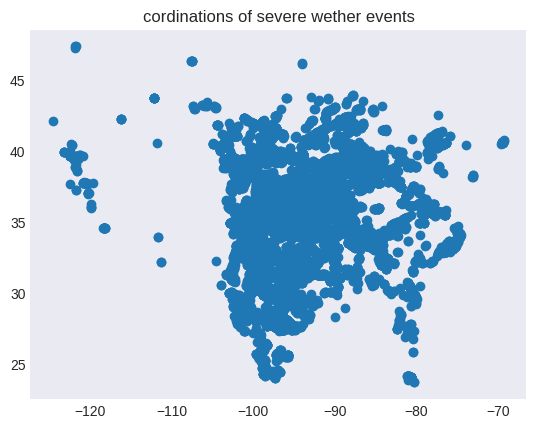

In [53]:
severe_data = data[data['SEVPROB'] >= 80]

plt.scatter(severe_data['LON'], severe_data['LAT'])
plt.title('cordinations of severe wether events')
plt.show()

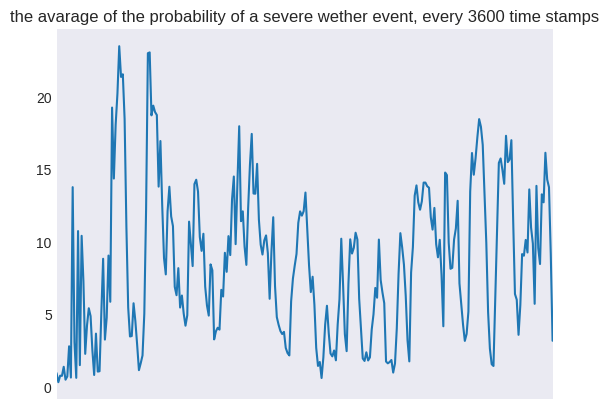

In [54]:
''' 
looks like most severe wether events occurre close to the soth or east cost
and a bit around the louisiana
'''

data['SEVPROB'].resample('H').mean().plot()
plt.title('the avarage of the probability of a severe wether event, every 3600 time stamps')
plt.xticks([])
plt.show()

In [55]:
''' avraging over every 60 time stamps '''

data = data.resample('T').mean()
data.head()

,LON,LAT,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0 days 00:00:00,-98.418219,31.068868,48.216667,196.633333,0.166667,40.666667,0.491667
0 days 00:01:00,-96.961912,32.544097,28.466667,172.550000,0.500000,33.000000,0.483333
0 days 00:02:00,-96.886162,32.836266,17.416667,173.150000,0.500000,26.833333,0.500000
0 days 00:03:00,-97.020589,32.899137,21.250000,215.716667,0.000000,26.833333,0.500000
0 days 00:04:00,-97.023409,33.054803,15.333333,219.350000,0.000000,23.333333,0.500000


In [56]:
''' we are interested in predicting the probabilty of a severe wether event'''

data, target = data.drop('SEVPROB', axis = 1), data['SEVPROB']

data.shape, target.shape

((16667, 6), (16667,))

In [57]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.15, random_state = 3)

train_data.shape, test_data.shape, train_target.shape, test_target.shape

((14166, 6), (2501, 6), (14166,), (2501,))

#### Applying the ML models

In [58]:
# for the metric sensetive models we use the more rubost: Quntile Scaler

knn_pipe = Pipeline([('scale', QuantileTransformer()),
                     ('model', KNeighborsRegressor())])

knn = GridSearchCV(estimator = knn_pipe, cv = 3, param_grid = {'model__n_jobs' : [5, 7, 9], 'model__p' : [1, 2]})

svm = Pipeline([('scale', StandardScaler()),
                ('model', SVR())])

forest_pipe = Pipeline([('scale', QuantileTransformer()),
                        ('mpdel', RandomForestRegressor())])

random_forest = GridSearchCV(estimator = forest_pipe, cv = 3, param_grid = {'mpdel__max_features': [3, 4],
                                                                            'mpdel__n_estimators' : [100, 150, 200],
                                                                            'mpdel__min_samples_leaf' : [30, 50]})

gradient_boost = xg.XGBRegressor(n_estimators = 200)


# model evaluation
def print_metric(pred): print(f'MSE: {metrics.mean_absolute_error(test_target, pred)}\nR2: {metrics.r2_score(test_target, pred)}')

In [59]:
knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 2.1424230307876853
R2: 0.8038276904552987


In [61]:
svm.fit(train_data, train_target)
print_metric(svm.predict(test_data))

MSE: 2.0297718160427745
R2: 0.8253003506445985


In [62]:
random_forest.fit(train_data, train_target)
print_metric(random_forest.predict(test_data))

MSE: 2.1125978604685267
R2: 0.8198775931079855


In [63]:
gradient_boost.fit(train_data, train_target)
print_metric(gradient_boost.predict(test_data))

MSE: 2.032690412454892
R2: 0.8296140164099549


#### harder challange: anticipate the future

In [64]:
def stack_time_series(before: int, after: int):

    ''' reshaping the data so that the challange is: given 'before' minutes of record predict the next 'after' '''

    stacked_target = pd.DataFrame( zip( * (list(target)[before + i:] for i in range(after))) )
    
    stacked_data = { col : pd.DataFrame( zip( * (list(data[col])[i:] for i in range(before))) )  for col in data.columns }

    return pd.concat(stacked_data, axis = 1)[:-after], stacked_target

In [65]:
data, target = stack_time_series(3, 1)
data.head()

LON                              LAT                        \
           0          1          2          0          1          2   
0 -98.418219 -96.961912 -96.886162  31.068868  32.544097  32.836266   
1 -96.961912 -96.886162 -97.020589  32.544097  32.836266  32.899137   
2 -96.886162 -97.020589 -97.023409  32.836266  32.899137  33.054803   
3 -97.020589 -97.023409 -96.474173  32.899137  33.054803  32.766937   
4 -97.023409 -96.474173 -94.576301  33.054803  32.766937  32.490277   

       RANGE                           AZIMUTH                          \
           0          1          2           0           1           2   
0  48.216667  28.466667  17.416667  196.633333  172.550000  173.150000   
1  28.466667  17.416667  21.250000  172.550000  173.150000  215.716667   
2  17.416667  21.250000  15.333333  173.150000  215.716667  219.350000   
3  21.250000  15.333333  33.016667  215.716667  219.350000  201.500000   
4  15.333333  33.016667  82.750000  219.350000  201.500000  166.366667   

        PROB                         MAXSIZE                      
           0          1          2         0         1         2  
0  40.666667  33.000000  26.833333  0.491667  0.483333  0.500000  
1  33.000000  26.833333  26.833333  0.483333  0.500000  0.500000  
2  26.833333  26.833333  23.333333  0.500000  0.500000  0.500000  
3  26.833333  23.333333  36.000000  0.500000  0.500000  0.500000  
4  23.333333  36.000000  24.166667  0.500000  0.500000  0.333333

In [66]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.15, random_state = 3)
train_data.shape, test_data.shape, train_target.shape, test_target.shape

((14164, 18), (2500, 18), (14164, 1), (2500, 1))

In [67]:
knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 3.088626666666667
R2: 0.5574734401339517


In [68]:
gradient_boost.fit(train_data, train_target)
print_metric(gradient_boost.predict(test_data))

MSE: 3.203525129294892
R2: 0.5466261673461703


In [72]:
svm.fit(train_data, train_target[0])
print_metric(svm.predict(test_data))

MSE: 3.10773356717349
R2: 0.545234616583165


In [71]:
random_forest.fit(train_data, train_target[0])
print_metric(random_forest.predict(test_data))

MSE: 3.245064957065382
R2: 0.536560757195001
